In [2]:
%load_ext autoreload
%autoreload 2
%cd /home/ezrae/Evolution-of-Statistical-Induction-Heads
import training_pipeline
import datasets
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import graphing_pipeline
import test_error
import utils
import importlib
sns.set_context("paper", font_scale=1.5)
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# training_pipeline.device = "cpu"
device = training_pipeline.device

default = training_pipeline.get_default_config()
histories = []
datem = []
bigram_data = []
unigram_data = []
seeds = [0]
path = "blog"
def get_test_sets(config):
  bigram_dataset = datasets.doubly_stochastic('test', config.block_size+1, num_symbols = config.vocab_size,)
  unigram_dataset = datasets.unigram('test', config.block_size+1, num_symbols=config.vocab_size)
  
  return bigram_dataset, unigram_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ezrae/Evolution-of-Statistical-Induction-Heads


n=2
config seed: 0
number of parameters: 5440
running on device cuda:0
iter_dt 0.00 ms; iter 0: train loss 0.715463
iter_dt 5.34 ms; iter 100: train loss 0.592073
iter_dt 5.26 ms; iter 200: train loss 0.543008
iter_dt 5.06 ms; iter 300: train loss 0.506258
iter_dt 5.37 ms; iter 400: train loss 0.532902


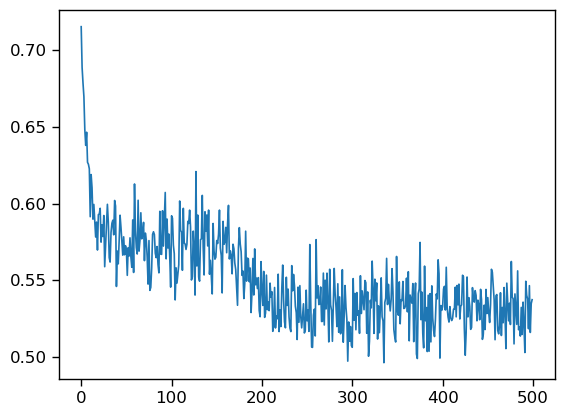

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ezrae/miniconda3/envs/icl_task_vectors/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/ezrae/miniconda3/envs/icl_task_vectors/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/home/ezrae/miniconda3/envs/icl_task_vectors/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/ezrae/miniconda3/envs/icl_task_vectors/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/ezrae/miniconda3/envs/icl_task_vectors/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 211, in collate_tensor_fn
    numel = sum(x.numel() for x in batch)
  File "/home/ezrae/miniconda3/envs/icl_task_vectors/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 211, in <genexpr>
    numel = sum(x.numel() for x in batch)
AttributeError: 'list' object has no attribute 'numel'


In [18]:
n = 2
from torch.profiler import profile, record_function, ProfilerActivity

# from datasets import ngrams
default = training_pipeline.get_default_config()
histories, datem, bigram_data, unigram_data = [], [], [], []
# default.model_type = f'one head (attention only, corrected rel pos)'
default.model_type = "transformer"
# default.model_type = 'Attention-Only Relative positions Transformer'
print(f"n={n}")
default.vocab_size = 2
default.n_head = n - 1
# default.n_head = 1
default.n_embd = 16 * default.n_head #* 3
default.n_layer = 2
default.max_iters = 500
default.n = n
default.block_size = 100
default.batch_size = 128
# default.batch_size = 64
# default.dataset = datasets.ngramArrows('train', n, default.block_size//2, default.vocab_size-1, last_token_only=False) 
default.dataset = datasets.ngrams('train', n, default.block_size+1, default.vocab_size, last_token_only=False, size=2000, offline = False) 
default.learning_rate = 4e-3
# default.learning_rate = 5e-4

name = f"{default.vocab_size}transformer_symb_{n}gram"
test_dataset = datasets.ngrams('test', n, default.block_size+1, default.vocab_size)
# test_dataset = datasets.ngramArrows('test', n, default.block_size//2, default.vocab_size-1)
# test_dataset = default.dataset
# if default.vocab_size < 4 and default.n == 2:
#     bigram_dataset, unigram_dataset = get_test_sets(default)
# default.dataset = datasets.doubly_stochastic_3('train', 1, n, default.block_size+1, num_symbols = default.vocab_size)
for seed in seeds:
    default.seed = seed
    model_history, train_loss = training_pipeline.train(default) 
    histories.append(model_history)
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

plt.plot(train_loss)
plt.show()
for model_history in histories:
    data = test_error.test_last_token(model_history, test_dataset, device)
    datem.append(data)
    
    # plt.plot(datem[-1][0])
    # if default.vocab_size < 4 and default.n == 2:
    #     data = test_error.test_last_token(model_history, bigram_dataset, device)
    #     bigram_data.append(data)
    #     data = test_error.test_last_token(model_history, unigram_dataset, device)
    #     unigram_data.append(data)

axes = graphing_pipeline.test_loss(datem, default) 
plt.legend()
plt.show()
# # plt.savefig(f"{path}/{name}_test_loss.pdf", format='pdf', bbox_inches='tight')
# plt.show()
# for lab, i in enumerate(datem[-1][1]):
#     plt.plot((i,)*len(datem[-1][0]), label = f"{lab}")
# plt.legend()
# plt.show()

# fig, axes = graphing_pipeline.pos_encode_graph(model_history, datem, default)
# # plt.savefig(f"{path}/{name}_pos.pdf", format='pdf', bbox_inches='tight')
# plt.show() 
# if default.vocab_size < 4 and default.n == 2:
#     fig, axes = graphing_pipeline.out_of_distribution(datem, unigram_data, bigram_data, default)
#     # plt.savefig(f"{path}/{name}_loss.pdf", format='pdf', bbox_inches='tight')
#     plt.show()
# axes = graphing_pipeline.similarity(datem, default)
# # plt.savefig(f"{path}/{name}_similarity.pdf", format='pdf', bbox_inches='tight')
# plt.show()

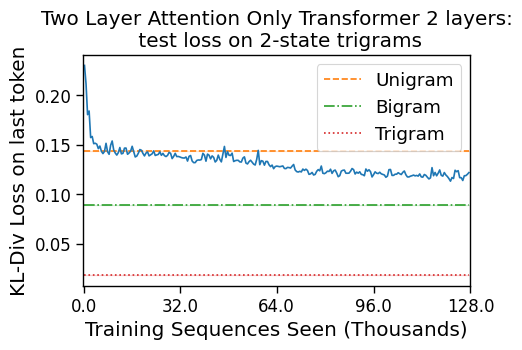

In [7]:
temp_test = test_error.test_last_token(model_history, test_dataset, device)
axes = graphing_pipeline.test_loss([temp_test], default) 
plt.legend()
plt.show()

In [5]:
n=2
default = training_pipeline.get_default_config()
histories, datem, bigram_data, unigram_data = [], [], [], []
default.model_type = 'Minimal Model'
default.max_iters = 200
default.vocab_size = 2
# default.learning_rate = 5e-3
default.batch_size = 128
# default.block_size = 1000
# default.learning_rate = 3e-4
default.learning_rate = 1e-2
# default.learning_rate = 1e-3

name = f"{default.vocab_size}symb_min_new"
test_dataset = datasets.ngrams('test', 2, default.block_size+1, default.vocab_size, last_token_only=False)
default.dataset = datasets.ngrams('train', 2, default.block_size+1, default.vocab_size, last_token_only=False)
# default.dataset = datasets.markov('train', default.block_size+1, default.vocab_size, last_token_only=True)
# default.dataset = datasets.unigram_3('train', 1, 2, default.block_size+1, num_symbols=default.vocab_size, last_token_only=True, uniform_prior=True)
# default.dataset = datasets.doubly_stochastic_3('train', 1, num_symbols=default.vocab_size, length=default.block_size+1, last_token_only=True)
# test_dataset = datasets.doubly_stochastic_3('test', 1, num_symbols=default.vocab_size, length=default.block_size+1, last_token_only=True)




bigram_dataset, unigram_dataset = get_test_sets(default)
for seed in seeds:
    default.seed = seed
    model_history, train_loss = training_pipeline.train(default) 
    histories.append(model_history)
plt.plot(train_loss)
plt.show()



# for model_history in histories:
#     data = test_error.test_last_token(model_history, test_dataset, device)
#     datem.append(data)

# axes = graphing_pipeline.test_loss(datem, default)
# plt.show()

# axes = graphing_pipeline.similarity(datem, default)
# plt.show()


# for model_history in histories:
#     if default.vocab_size < 4 and default.n == 2:
#         data = test_error.test_last_token(model_history, bigram_dataset, device)
#         bigram_data.append(data)
#         data = test_error.test_last_token(model_history, unigram_dataset, device)
#         unigram_data.append(data)
# for i in datem[-1][1]:
#     plt.plot((i,)*len(datem[-1][0]))
# for lab, i in enumerate(datem[-1][1]):
#     plt.plot((i,)*len(datem[-1][0]), label = f"{lab}")
# plt.legend()
# plt.plot(datem[-1][0])
# plt.show()

# axes = graphing_pipeline.pos_encode_graph(model_history, datem, default)
# # plt.savefig(f"{path}/{name}_pos.pdf", format='pdf', bbox_inches='tight')
# plt.show()

# if default.vocab_size < 4 and default.n == 2:
#     axes = graphing_pipeline.out_of_distribution(datem, unigram_data, bigram_data, default)
# #     # plt.savefig(f"{path}/{name}_loss.pdf", format='pdf', bbox_inches='tight')
#     plt.show()
# # plt.savefig(f"{path}/{name}_similarity.pdf", format='pdf', bbox_inches='tight')

config seed: 0
running on device cuda:0
iter_dt 0.00 ms; iter 0: train loss 0.693146
iter_dt 3.42 ms; iter 400: train loss 0.533037


KeyboardInterrupt: 

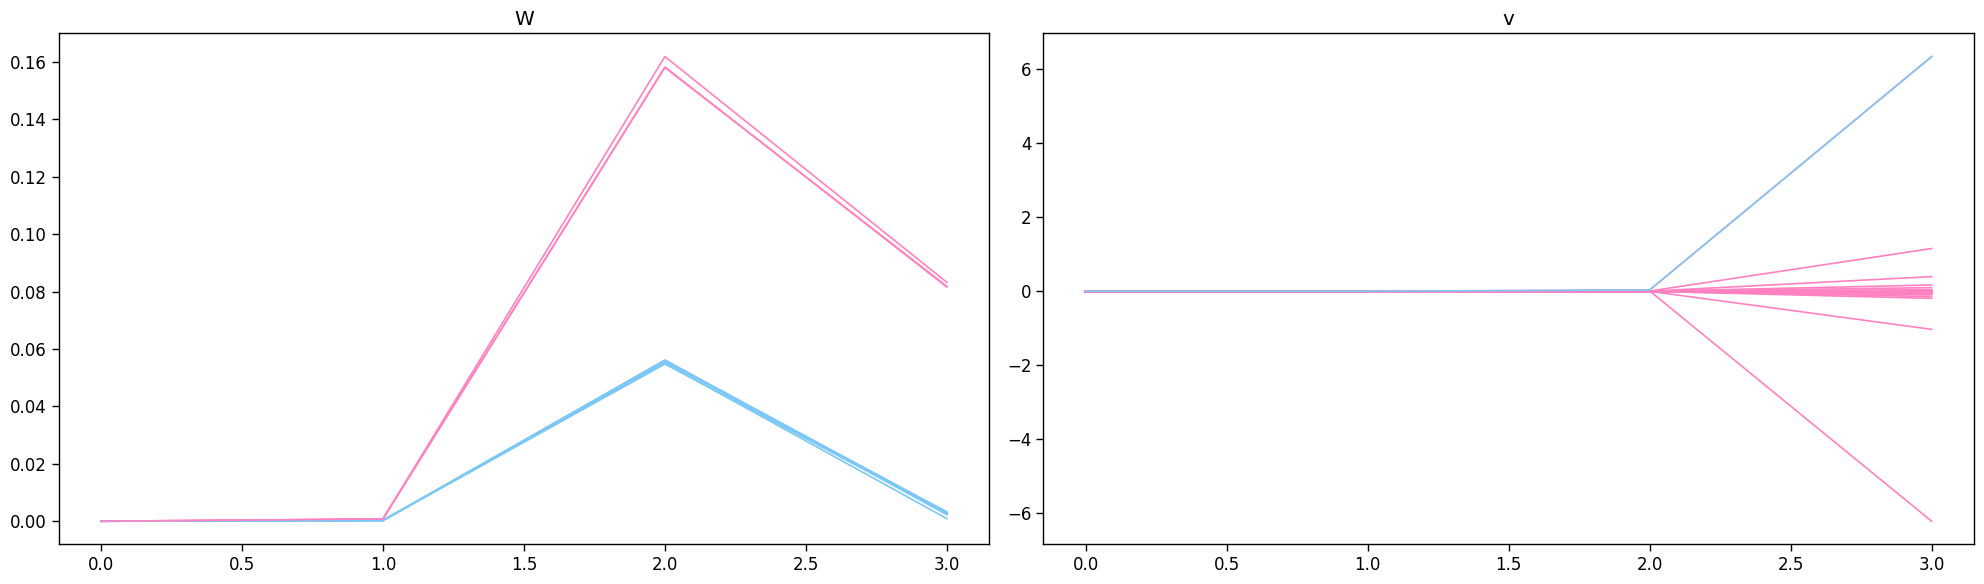

tensor([[-6.2107],
        [ 6.3374]])
tensor([[0.0818, 0.0029, 0.0031],
        [0.0023, 0.0832, 0.0009],
        [0.0033, 0.0028, 0.0815]])


In [50]:
model = histories[-1][-1]
with torch.no_grad():
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    # axs[0].plot([(m.Wq.weight.trace()/m.Wq.weight.sum()).cpu() for m in histories[-1]])

    for i in range(default.vocab_size):
        for j in range(default.vocab_size):
                if i == j:
                    continue
                axs[0].plot([(m.W.weight[i,j]).cpu() for m in histories[-1]], color="xkcd:lightblue")
        axs[0].plot([(m.W.weight[i,i]).cpu() for m in histories[-1]], color="xkcd:pink")
                # axs[1].plot([(m.Wv.weight[i,j]-1).cpu() for m in histories[-1]], color="xkcd:lightblue")
    # axs[0].plot([(m.Wq.weight-1).norm(p=1).cpu() for m in histories[-1]], color="xkcd:red")

    axs[0].set_title("W")
    # axs[1].plot([(m.Wv.weight[0,0]).cpu() for m in histories[-1]])
    # axs[1].plot([((m.v.weight[1])*(m.Wq.weight-1).trace()).cpu() for m in histories[-1]])
    # axs[1].set_title("Fraction")
    for i in range(default.block_size-1, -1, -1):
        axs[-1].plot([(m.v.weight[i]).cpu() for m in histories[-1]], color="xkcd:pink")
    
    axs[-1].plot([(m.v.weight[1]).cpu() for m in histories[-1]], color="xkcd:lightblue")
    # axs[2].plot([m.v.weight.cpu()[1] for m in histories[-1]])
    axs[-1].set_title("v")
    # plt.plot([m.v.weight.cpu()[1]/max(abs(m.v.weight.cpu())) for m in histories[-1]])
    plt.tight_layout()
    plt.show()
    # print(((model.Wv.weight[0,0])).cpu())
    print(((model.v.weight[:2])).cpu())
    print(((histories[-1][-1].W.weight)).cpu())

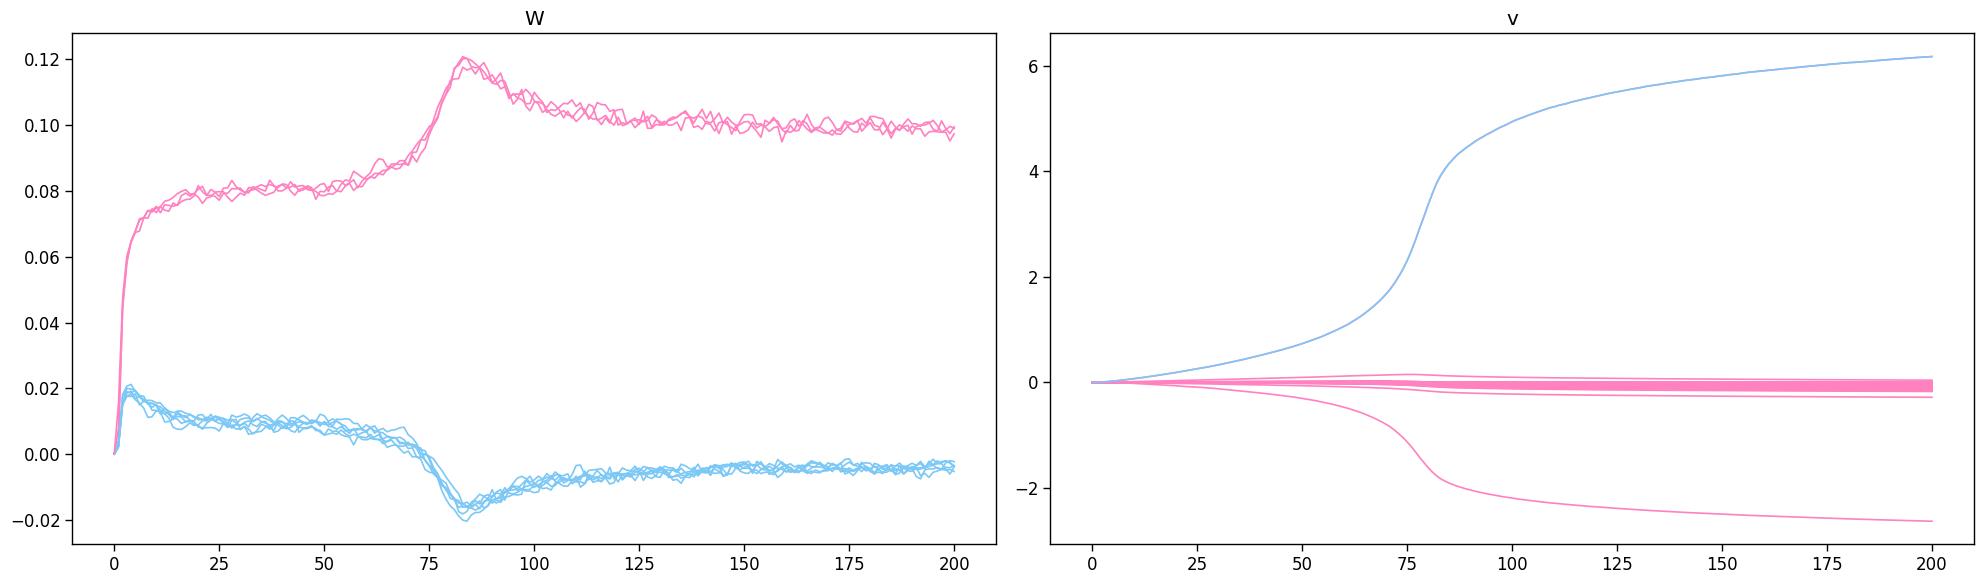

tensor([[-2.6351],
        [ 6.1757]])
tensor([[ 0.0995, -0.0039, -0.0023],
        [-0.0038,  0.0990, -0.0036],
        [-0.0035, -0.0053,  0.0974]])


In [11]:
model = histories[-1][-1]
with torch.no_grad():
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    # axs[0].plot([(m.Wq.weight.trace()/m.Wq.weight.sum()).cpu() for m in histories[-1]])

    for i in range(default.vocab_size):
        for j in range(default.vocab_size):
                if i == j:
                    continue
                axs[0].plot([(m.W.weight[i,j]).cpu() for m in histories[-1]], color="xkcd:lightblue")
        axs[0].plot([(m.W.weight[i,i]).cpu() for m in histories[-1]], color="xkcd:pink")
                # axs[1].plot([(m.Wv.weight[i,j]-1).cpu() for m in histories[-1]], color="xkcd:lightblue")
    # axs[0].plot([(m.Wq.weight-1).norm(p=1).cpu() for m in histories[-1]], color="xkcd:red")

    axs[0].set_title("W")
    # axs[1].plot([(m.Wv.weight[0,0]).cpu() for m in histories[-1]])
    # axs[1].plot([((m.v.weight[1])*(m.Wq.weight-1).trace()).cpu() for m in histories[-1]])
    # axs[1].set_title("Fraction")
    for i in range(default.block_size-1, -1, -1):
        axs[-1].plot([(m.v.weight[i]).cpu() for m in histories[-1]], color="xkcd:pink")
    
    axs[-1].plot([(m.v.weight[1]).cpu() for m in histories[-1]], color="xkcd:lightblue")
    # axs[2].plot([m.v.weight.cpu()[1] for m in histories[-1]])
    axs[-1].set_title("v")
    # plt.plot([m.v.weight.cpu()[1]/max(abs(m.v.weight.cpu())) for m in histories[-1]])
    plt.tight_layout()
    plt.show()
    # print(((model.Wv.weight[0,0])).cpu())
    print(((model.v.weight[:2])).cpu())
    print(((histories[-1][-1].W.weight)).cpu())

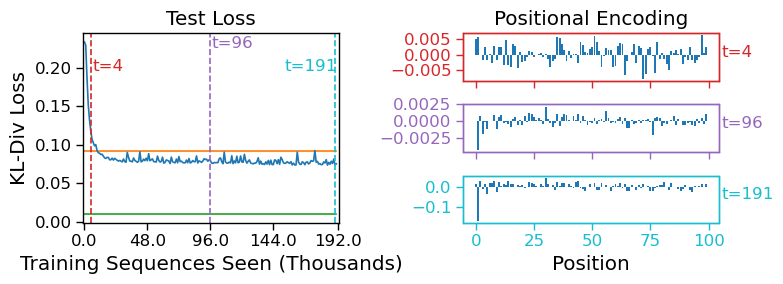

IndexError: list index out of range

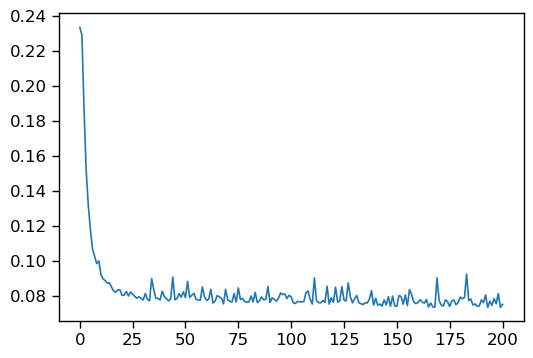

In [ ]:
# for data in datem:
# #     data = test_error.test_last_token(model_history, test_dataset, device)
# #     datem.append(data)
#     if default.vocab_size < 4 and default.n == 2:
#         data = test_error.test_last_token(model_history, bigram_dataset, device)
#         bigram_data.append(data)
#         data = test_error.test_last_token(model_history, unigram_dataset, device)
#         unigram_data.append(data)
# # for i in datem[-1][1]:
# #     plt.plot((i,)*len(datem[-1][0]))
# for lab, i in enumerate(datem[-1][1]):
#     plt.plot((i,)*len(datem[-1][0]), label = f"{lab}")
# plt.legend()
# plt.plot(datem[-1][0])
# plt.show()
# name +="_newmin"
axes = graphing_pipeline.pos_encode_graph(model_history, datem, default)
plt.savefig(f"{path}/{name}_pos.pdf", format='pdf', bbox_inches='tight')
plt.show()

if default.vocab_size < 4 and default.n == 2:
    axes = graphing_pipeline.out_of_distribution(datem, unigram_data, bigram_data, default)
    plt.savefig(f"{path}/{name}_loss.pdf", format='pdf', bbox_inches='tight')
    plt.show()
axes = graphing_pipeline.similarity(datem, default)
plt.savefig(f"{path}/{name}_similarity.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
with torch.no_grad():
    tot =0
    for history in histories:
        tot += abs(history[1].v.weight.cpu().numpy())
        # plt.plot(history[1].v.weight.cpu().numpy())
    plt.plot(tot/len(histories))
plt.show()

NameError: name 'torch' is not defined

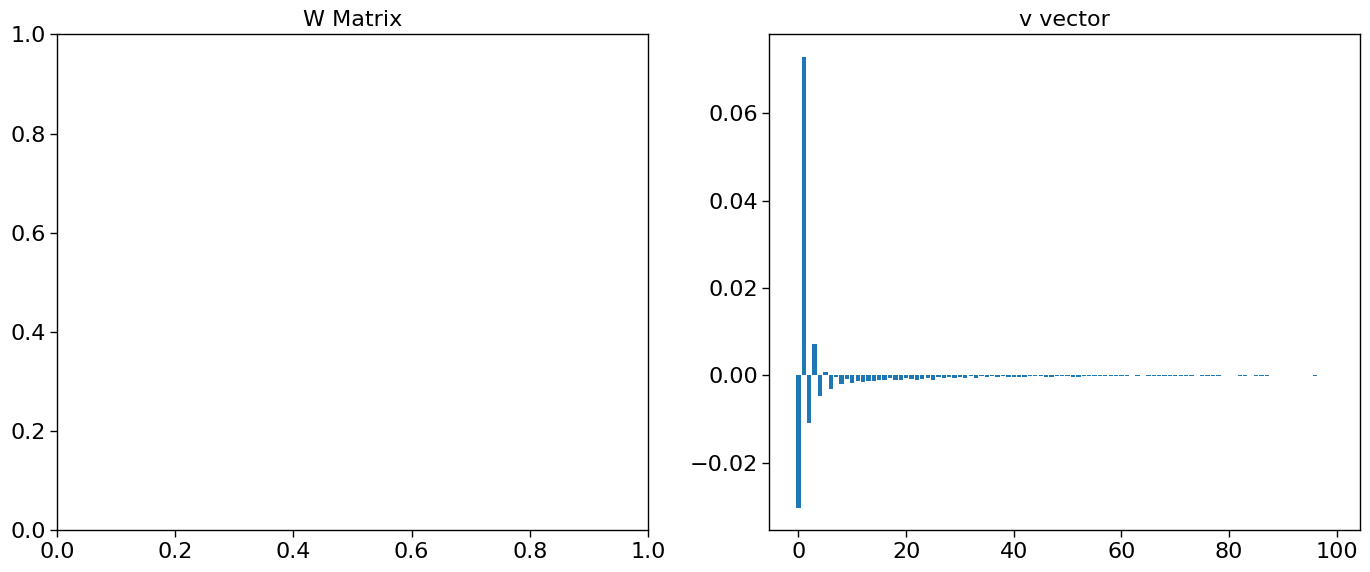

Parameter containing:
tensor([[-3.0377e-02],
        [ 7.2957e-02],
        [-1.0921e-02],
        [ 7.2771e-03],
        [-4.7066e-03],
        [ 8.4622e-04],
        [-3.0414e-03],
        [-3.3500e-04],
        [-2.0028e-03],
        [-8.6292e-04],
        [-1.7352e-03],
        [-1.2242e-03],
        [-1.5051e-03],
        [-1.2460e-03],
        [-1.2242e-03],
        [-1.0109e-03],
        [-1.1265e-03],
        [-7.2188e-04],
        [-1.1502e-03],
        [-9.8168e-04],
        [-6.9415e-04],
        [-8.3170e-04],
        [-1.0474e-03],
        [-8.9084e-04],
        [-5.8898e-04],
        [-9.7599e-04],
        [-4.9445e-04],
        [-6.5014e-04],
        [-3.0015e-04],
        [-5.3314e-04],
        [-4.8101e-04],
        [-5.5704e-04],
        [-2.3666e-04],
        [-6.0591e-04],
        [-1.6363e-04],
        [-2.7482e-04],
        [-2.5211e-04],
        [-3.6041e-04],
        [-1.9998e-04],
        [-3.6295e-04],
        [-4.3220e-04],
        [-3.8265e-04],
        [-4.

In [ ]:
model = histories[-1][-1]
with torch.no_grad():
    #increase font size
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['xtick.labelsize']=16
    plt.rcParams['ytick.labelsize']=16
    # idx = torch.tensor([[0,1,2,0]*25]).cuda()
    # print(model(idx)[0][0,-1])
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap((model.Wq.weight).cpu().numpy(), ax=axs[0], square=True)
    axs[0].set_title("W Matrix", fontsize=16)
    # sns.heatmap(model.Wv.weight.cpu().numpy(), ax=axs[1], square=True)
    # axs[1].set_title("Wv")
    axs[1].bar(range(100),height=model.v.weight.cpu().numpy().squeeze())
    axs[1].set_title("v vector", fontsize=16)
    # sns.heatmap(model.layer_two.Wk.weight.cpu().numpy(), ax=axs[1, 2], square=True)
    # axs[1,2].set_title("Layer 2 Wk")

        
    plt.tight_layout()
    plt.savefig(f"{path}/{name}_parameters.pdf", format='pdf', bbox_inches='tight')
    plt.show()

print(model.v.weight)

0
1
2
3
4


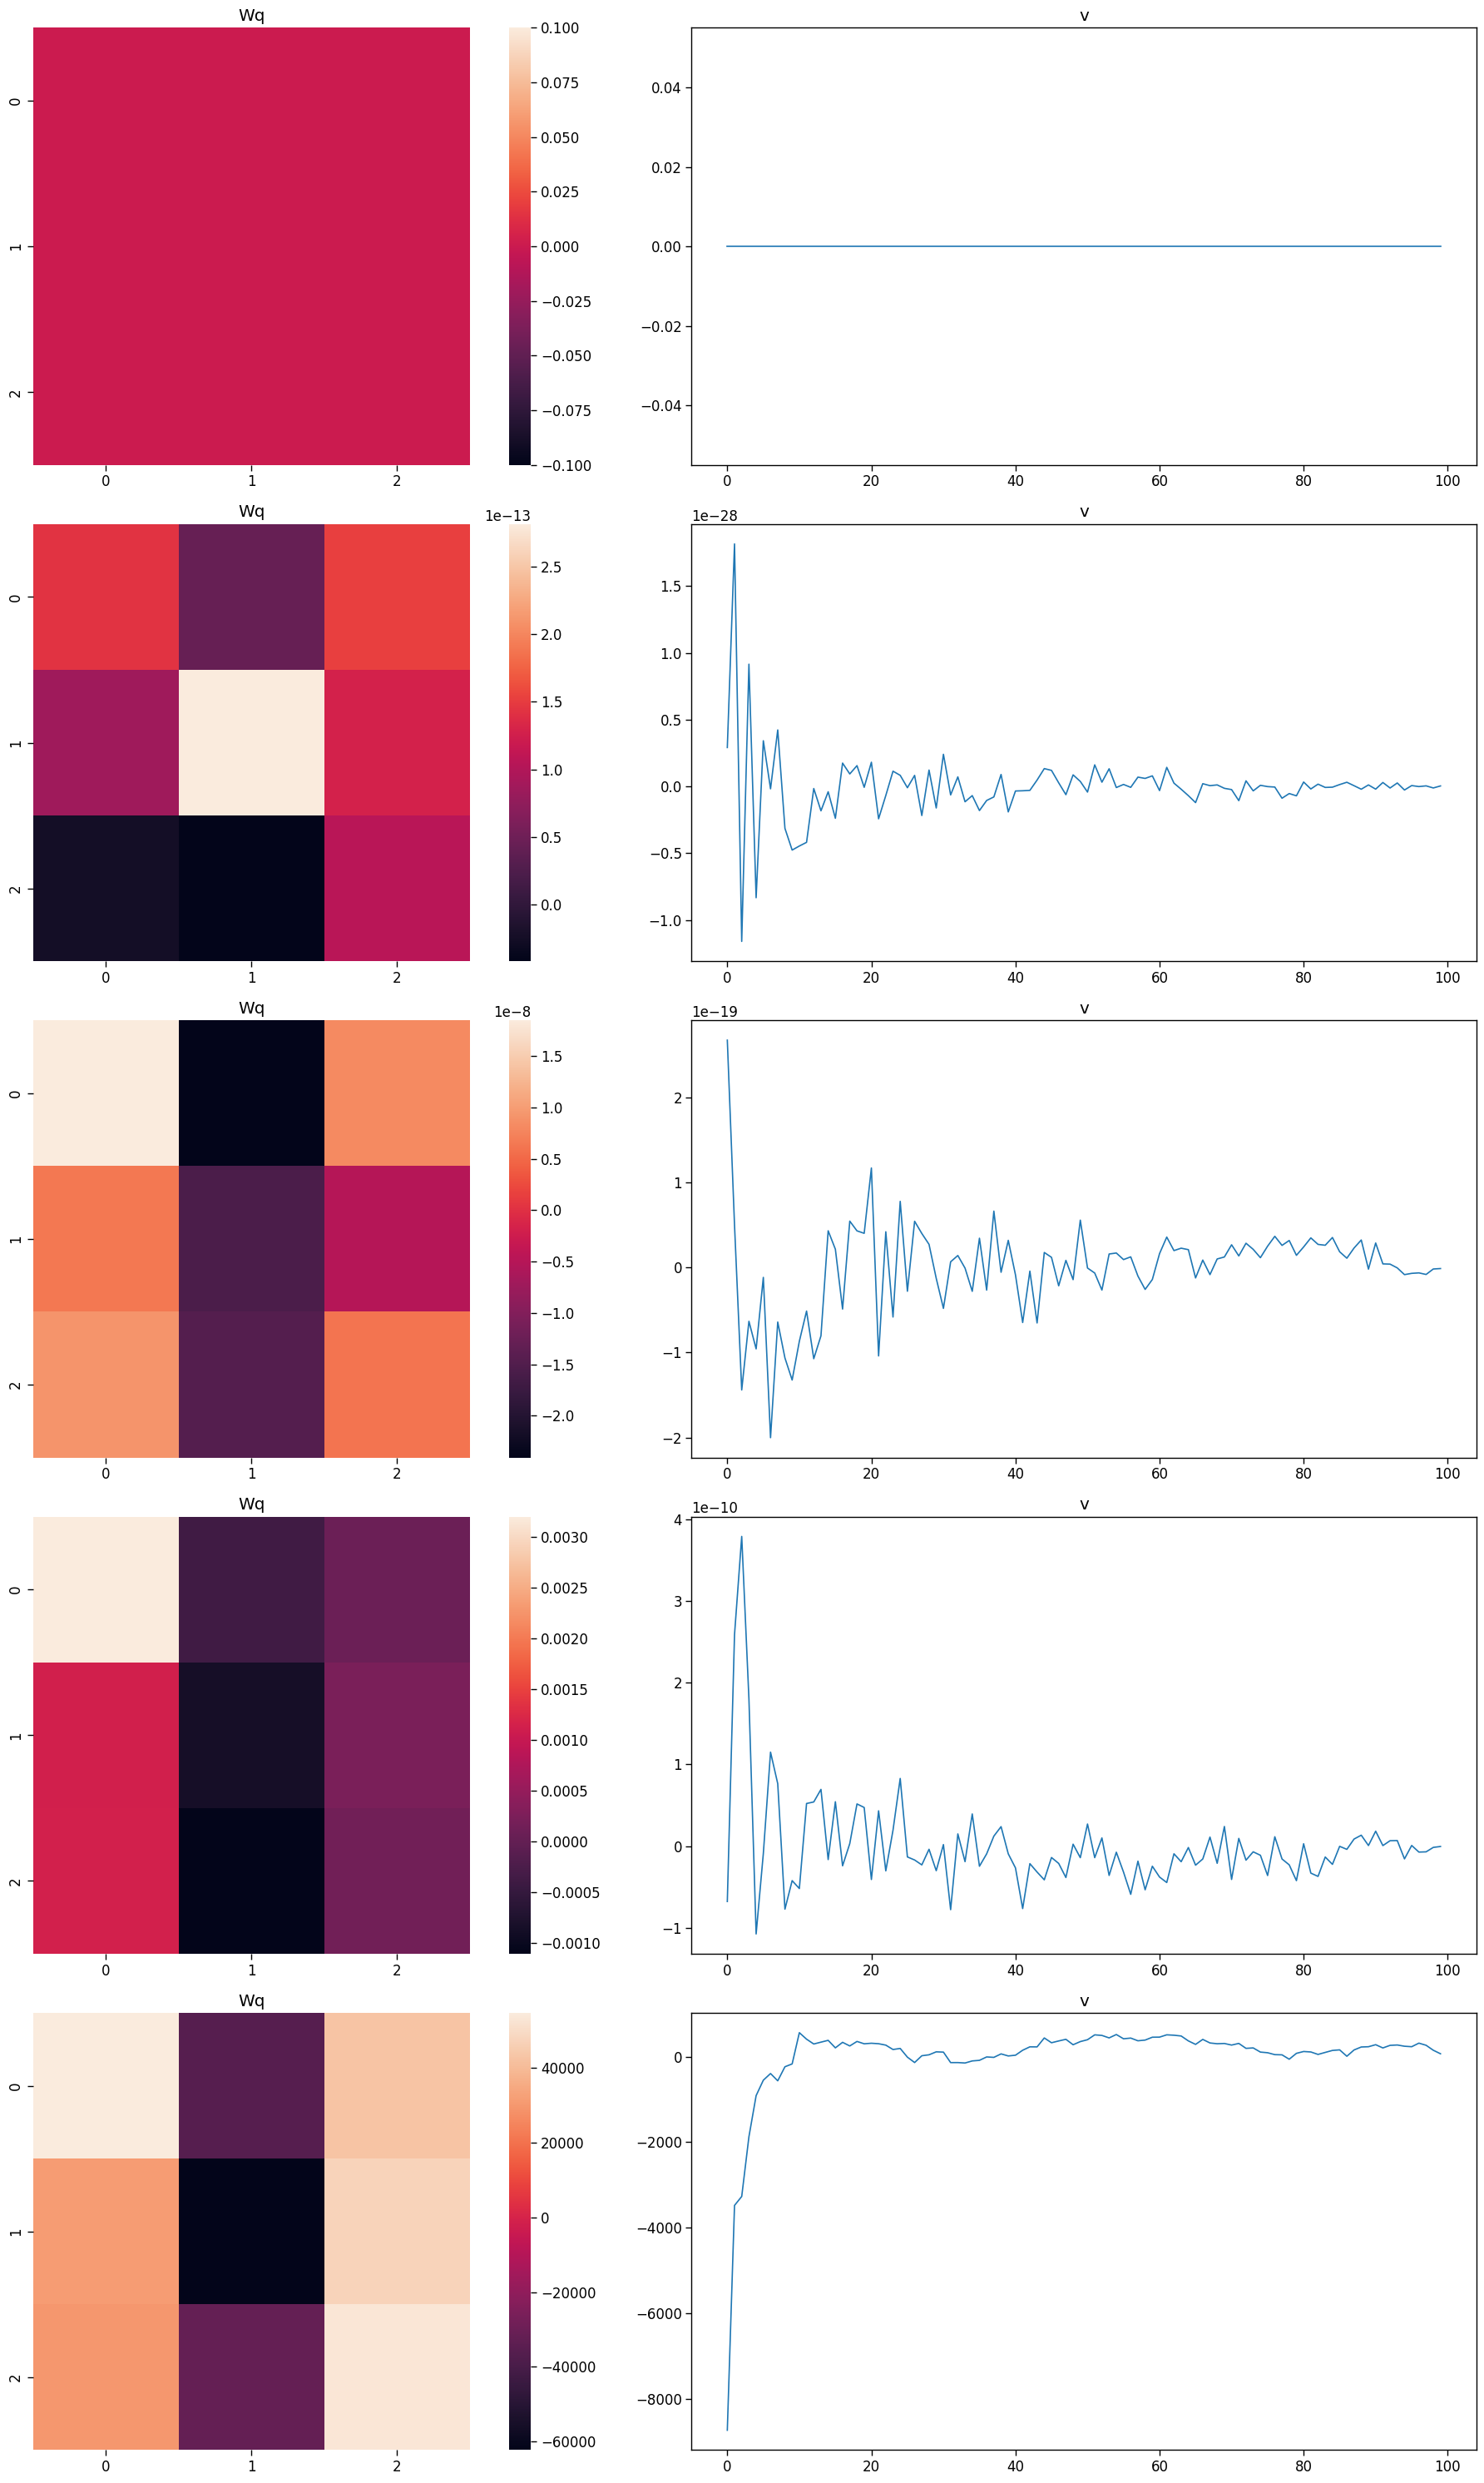

In [ ]:
n = 5
fig, axs = plt.subplots(n, 2, figsize=(20, 6*n))
with torch.no_grad():
    for i, model in enumerate(histories[-1][:n*4:4]):
        idx = torch.tensor([[0,1,2,0]*25]).cuda()
        print(i)
        sns.heatmap((model.Wq.weight-histories[-1][0].Wq.weight[0,0]).cpu().numpy(), ax=axs[i, 0], square=True)
        axs[i, 0].set_title("Wq")
        # sns.heatmap(model.Wv.weight.cpu().numpy(), ax=axs[i, 1], square=True)
        # axs[i, 1].set_title("Wv")
        axs[i, 1].plot(model.v.weight.cpu().numpy())
        axs[i, 1].set_title("v")
        # sns.heatmap(model.layer_two.Wk.weight.cpu().numpy(), ax=axs[1, 2], square=True)
        # axs[1,2].set_title("Layer 2 Wk")
        
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
# print(np.argmin(datem[-1][0][:24]))
# mini = np.argmin(datem[-1][0][:24])
mini=12
# print(min(datem[-1][0][:24]))
with torch.no_grad():
    # print(model_history[mini].W.weight.cpu())
    print(model_history[1].W.weight.cpu())
    print(model_history[-1].v.weight.sum())
    print(((model_history[-1].v.weight[1])/model_history[-1].v.weight.norm(1)).cpu())
    plt.plot([((m.v.weight[1])/m.v.weight.norm(1)).cpu() for m in model_history])
    plt.sTruehow()
    test = []
    diags = []
    offdiags = []
    for m in model_history:
        tr = m.W.weight.trace()
        diag = tr/default.vocab_size
        offdiag = (m.W.weight.sum()-tr)/(default.vocab_size**2-default.vocab_size)
        diags.append(diag.cpu())
        offdiags.append(offdiag.cpu())

        # test.append((diag/offdiag).cpu())
    plt.plot(diags, label="diagonal")
    plt.plot(offdiags, label="off diagonal")
    plt.legend()
    plt.show()
    # print(f"test: {test[mini]}")
    # plt.plot(model_history[-100].v.weight.cpu())
    # plt.show()

    plt.plot(model_history[0].v.weight.cpu())
    plt.plot(model_history[-1].v.weight.cpu())
    plt.show()

AttributeError: 'min_model' object has no attribute 'W'

In [ ]:
import copy
m = copy.deepcopy(model_history[-1])
m.v.weight = torch.nn.Parameter(torch.eye(3))


TypeError: doubly_stochastic_3.__init__() got an unexpected keyword argument 'uniform_prior'

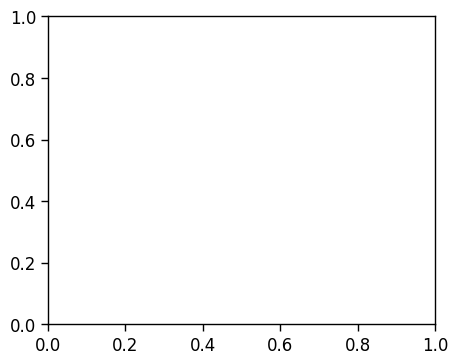

In [ ]:
default = training_pipeline.get_default_config()
default.model_type = 'Transformer'
default.max_iters = 2000
# default.learning_rate = 1e-2
# default.learning_rate = 3e-3
default.vocab_size=3

name = f"{default.vocab_size}symb_uniformxt"

spectrum_data = graphing_pipeline.mixtures(default,11)

plt.savefig(f"{path}/{name}_ds_test_loss.pdf", format='pdf', bbox_inches='tight')
plt.show()

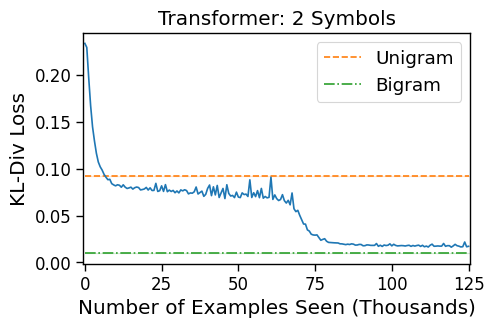

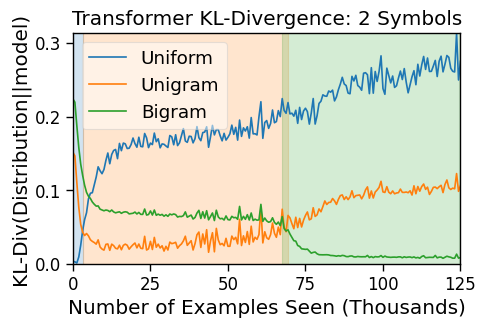

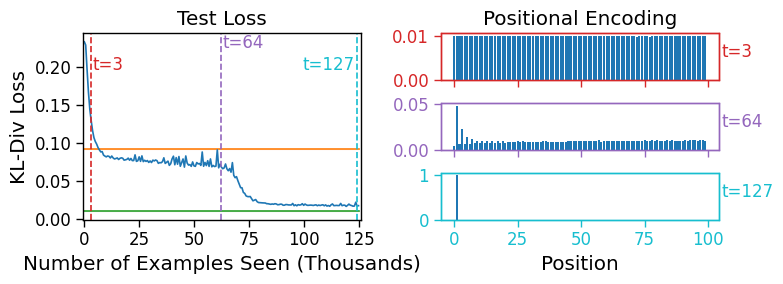

In [ ]:

import graphing_pipeline
importlib.reload(graphing_pipeline)
import test_error
importlib.reload(test_error)
# sns.set_palette("colorblind")
# plt.rcParams.update({'font.size': 12})
# points = [5, 145, 190] # 3symb seed 0
# points = [5, 100, 190] # 2symb seed 0
points = [5, 60, 190] # min 3symb seed 0
# points = [5, 15, 190] # min 2symb seed 0

sns.set_context("paper", font_scale=1.5)
import matplotlib
matplotlib.rcParams.update({'xtick.labelsize': 12})

matplotlib.rcParams.update({'ytick.labelsize': 12})

# default.model_type = 'Transformer Tetragram'
axes = graphing_pipeline.test_loss(datem, default)
plt.savefig(f"{path}/{name}_loss.pdf", format='pdf', bbox_inches='tight')
plt.show()
axes = graphing_pipeline.similarity(datem, default)
plt.savefig(f"{path}/{name}_similarity.pdf", format='pdf', bbox_inches='tight')
plt.show()
fig, axes = graphing_pipeline.pos_encode_graph(model_history, datem, default)
plt.savefig(f"{path}/{name}_pos.pdf", format='pdf', bbox_inches='tight')
plt.show()
# fig, axes = graphing_pipeline.out_of_distribution(datem, unigram_data, bigram_data, default)
# plt.savefig(f"{path}/{name}_loss.pdf", format='pdf', bbox_inches='tight')
# plt.show()

torch.Size([100, 201])


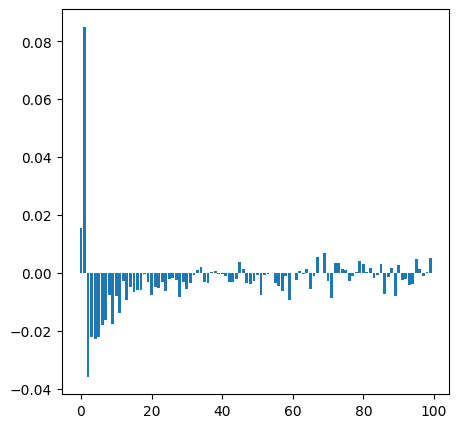

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pos_dat = test_error.pos_enc(model_history, default)
pos_dat = torch.mean(pos_dat, axis=0)
print(pos_dat.shape)
plt.bar(range(default.block_size), pos_dat[:,70])
plt.savefig(f"test_pos.pdf", format='pdf', bbox_inches='tight')
plt.show()

tensor([[0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 2]], device='cuda:0')


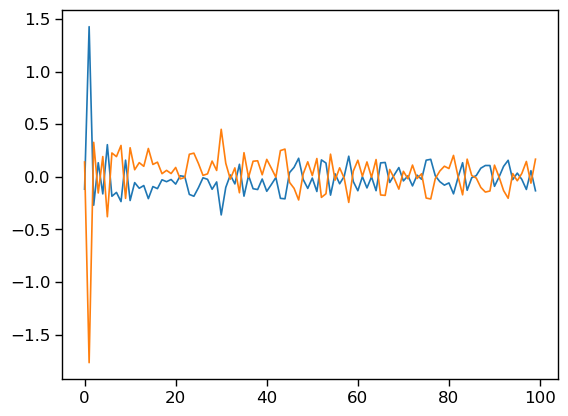

In [ ]:
importlib.reload(graphing_pipeline)
from random import choices
points = [40, 160, 190]
points = [5, 145, 190]
points = [200]
idx = torch.tensor([list(choices(range(default.vocab_size), k=15))]).cuda()
unigram = datasets.unigram_3("test", 1, 2, default.block_size+1, num_symbols=default.vocab_size)
idx = torch.stack([unigram[0][0][:24]]).to(device)
idx = torch.tensor([[0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 2]]).cuda()
# idx = torch.stack([test_dataset[0][0]]).to(device)
print(idx)
# idx = torch.tensor([[0, 0,2,0,0,0,1,0,0, 2,0,0,0,0,0,0, 0,0]]).cuda()

# _= graphing_pipeline.attention(default, model_history, points, datem[0], idx = idx)
# plt.savefig(f"final/{name}_attn_maps.pdf", format='pdf', bbox_inches='tight')
# plt.plot()
with torch.no_grad():
    for model_history in histories:
        for i in range(default.vocab_size):
            plt.plot((test_error.pos_enc(model_history, default)[i][:100,-1]))
        plt.show()
        # graphing_pipeline.attention_at(model_history, points, idx)
        # plt.savefig(f"{path}/{name}_ds_attn.pdf", format='pdf', bbox_inches='tight')
        # plt.show()
        # print(model_history[-1](idx)[0][0][-1])
        # print(model_history[-1].layers[0].wpe.weight.cpu())
    # _= graphing_pipeline.attention(default, model_history, points, datem[0], idx = idx, layer = 1)

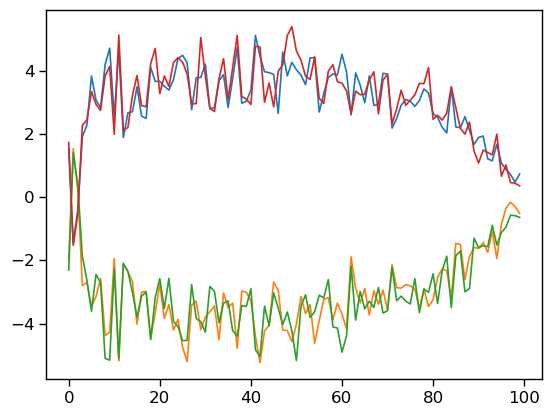

In [15]:
with torch.no_grad():
    m= model_history[-1]
    num_tokens = default.vocab_size
    # embds = m.layers[1].ln(m.wte(torch.Tensor(list(range(num_tokens))).long().to(device)).float())
    # sns.heatmap(model_history[-1].layers[1].V(embds).cpu())

    plt.plot(m.layers[0].wpe_k(torch.Tensor(list(range(100))).long().to(device)).float().cpu())

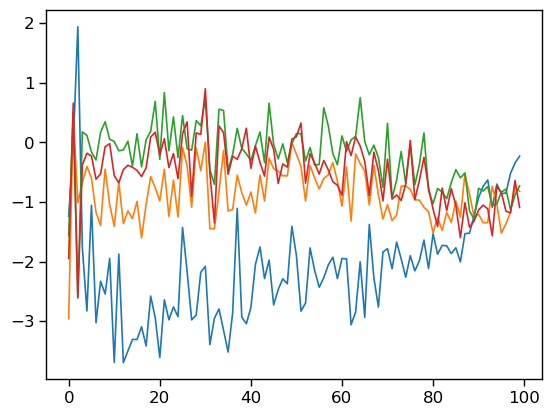

In [16]:
with torch.no_grad():
    m= model_history[-1]
    num_tokens = default.vocab_size
    # embds = m.layers[1].ln(m.wte(torch.Tensor(list(range(num_tokens))).long().to(device)).float())
    # sns.heatmap(model_history[-1].layers[1].V(embds).cpu())

    plt.plot(m.layers[0].wpe_v(torch.Tensor(list(range(100))).long().to(device)).float().cpu())

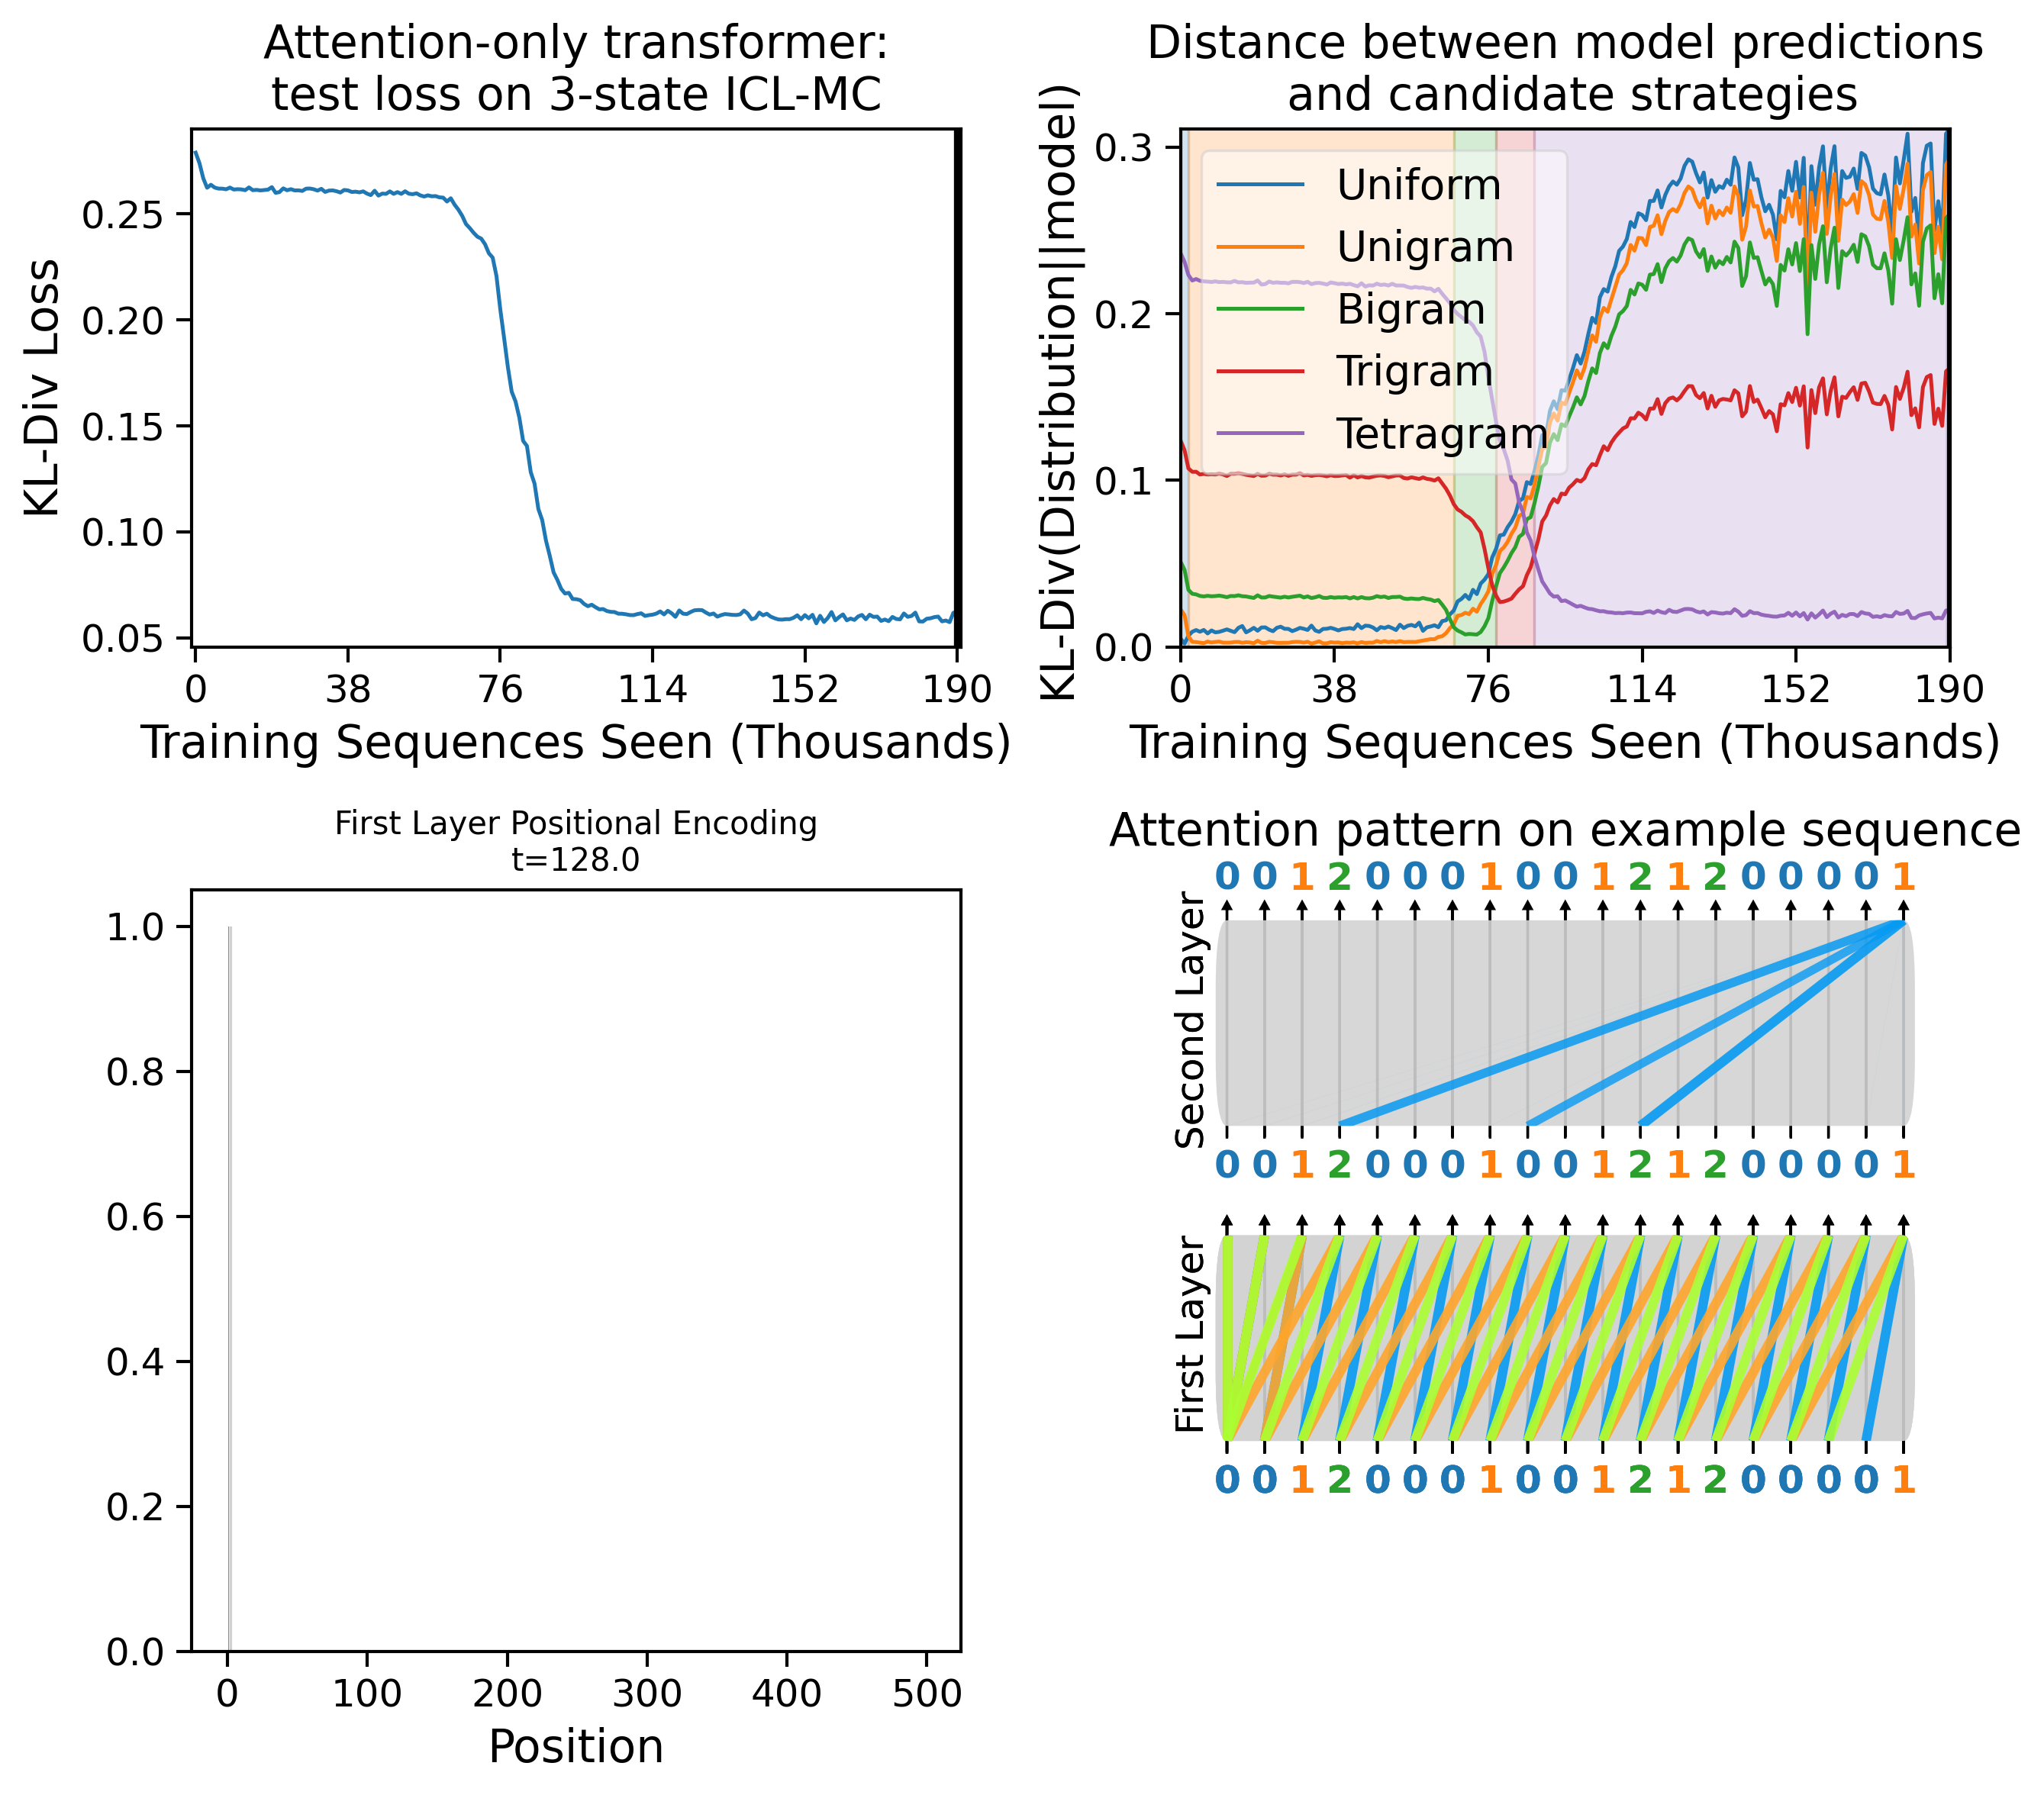

In [ ]:
# idx = torch.tensor([[0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 2]]).cuda()
from random import choices
importlib.reload(graphing_pipeline)
# idx = torch.tensor([[0, 2, 3, 2, 0, 0, 3, 3, 3, 3, 2, 3, 2, 0, 2, 3]], device=device)
# idx = torch.tensor([[0, 2, 3, 2, 0, 2, 3, 3, 3, 3, 2, 3, 2, 0, 2, 3]], device=device)
# idx = torch.tensor([list(choices(range(default.vocab_size), k=15))]).cuda()
# idx = torch.tensor([[0,1,2]+ [0,0,1]+[1,1,0]+[0,1]], device = device)

x = test_dataset[0]
idx = torch.stack([test_dataset[0][0][:24]]).to(device)
idx = torch.tensor([[0, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1]], device='cuda:0')
if n == 4:
    idx = torch.tensor([[0,0,1,2]+ [0,0,0,1]+[0,0,1,2]+[1,2,0,0]+[0,0,1]], device = device)
FFwriter = matplotlib.animation.FFMpegWriter(fps=20)
with torch.no_grad():
    # animation = graphing_pipeline.animate_attn(default, model_history, datem[-1], idx)
    animation = graphing_pipeline.animation(default, model_history, datem[-1], idx)
    

    # animation.save(f'{path}/mc-icl.mp4', writer=FFwriter)
    animation.save(f'{path}/surbhi_tetragrams.mp4', writer=FFwriter)
    plt.show()

tensor([[1, 2, 2, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0,
         1, 1, 0, 2, 2, 0, 1, 2]], device='cuda:0')


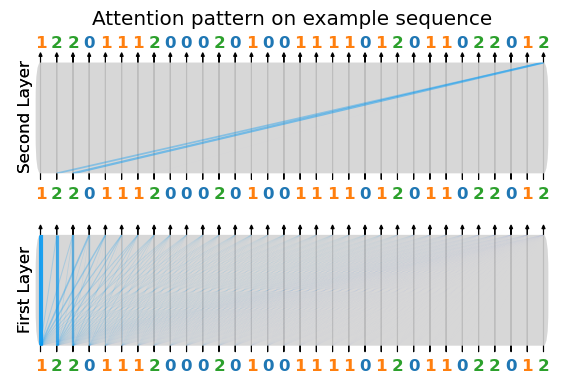

In [ ]:
model_history = histories[-1]
from random import choices
with torch.no_grad():
    
    # x = torch.tensor([list(choices(range(default.vocab_size), k=16))]).to(device)
    # x = torch.tensor([[0,1,2,3,0,1,2,3,0,1,2,3]], device = device)
    # idx = x
    # test_dataset = datasets.ngrams_simple('test', default.n, default.block_size+1, default.vocab_size)
    x = test_dataset[0]
    x = test_dataset[0]
    idx = torch.stack([test_dataset[0][0][:16]]).to(device)
    # idx = torch.tensor([[1, 3, 4, 6, 3, 4, 4, 3, 6, 1, 7, 7, 3, 0, 2, 0, 3, 1, 6, 4, 7, 5, 6, 7]], device='cuda:0')
    print(idx)
    # idx = torch.tensor([[0,1,2]*5+[0,1,0]*2 + [0,0,1]+[1,1,0]+[0,1]], device = device)
    # idx = torch.tensor([[0,1,2]*3+ [0,0,1]+[1,1,0]+[0,1]], device = device)
    # idx = torch.tensor([[0,0,1,2]*3+ [0,0,0,1]+[1,1,1,0]+[0,0,1]], device = device)

    # # idx = torch.tensor([[0,1,2,3,1,1,2,3,0,1,2,3]], device = device)
    # print(idx)
    # graphing_pipeline.multi_head_attention_at(model_history, idx, frame = 120)
    # plt.show()
    # graphing_pipeline.multi_head_attention_at(model_history, idx, frame = 140)
    # plt.show()
    graphing_pipeline.multi_head_attention_at(model_history, idx, frame = 190)
    plt.show()
    